In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

In [2]:
data_dir = "/home/pervinco/Datasets/BKAI_IGH_NeoPolyp"
image_dir = f"{data_dir}/train"
mask_dir = f"{data_dir}/train_mask"

image_files = sorted(glob(f"{image_dir}/*"))
mask_files = sorted(glob(f"{mask_dir}/*"))
print(len(image_files), len(mask_files))

1000 1000


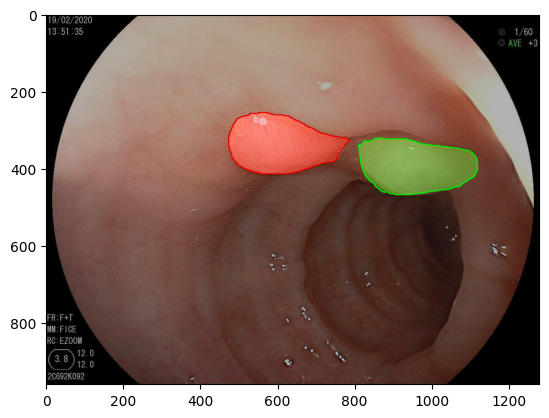

In [8]:
def decode_mask(pred_mask):
        decoded_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
        decoded_mask[pred_mask == 0] = [0, 0, 0]
        decoded_mask[pred_mask == 1] = [0, 255, 0] ## Green
        decoded_mask[pred_mask == 2] = [255, 0, 0] ## Red
        
        return decoded_mask

def extract_contours_from_mask(mask_image_path):
    mask = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)
    unique_labels = np.unique(mask)

    yolo_format_data = []

    for label in unique_labels:
        if label == 0:  # Skip background
            continue
        binary_mask = (mask == label).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            flattened_contour = contour.flatten()
            normalized_coords = [coord / mask.shape[i % 2] for i, coord in enumerate(flattened_contour)]
            yolo_format_data.append([label] + normalized_coords)

    return yolo_format_data

def draw_contours_on_image(image_path, mask_image_path, yolo_data):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)
    mask = decode_mask(mask)
    
    for data in yolo_data:
        label = data[0]
        coords = data[1:]
        denormalized_coords = [(int(coord * image.shape[i % 2])) for i, coord in enumerate(coords)]
        contour = np.array(denormalized_coords).reshape(-1, 1, 2)
        if label == 1:
            cv2.drawContours(image, [contour], 0, (0, 255, 0), 2)
        elif label == 2:
            cv2.drawContours(image, [contour], 0, (255, 0, 0), 2)

    image = cv2.addWeighted(image, 0.7, mask, 0.3, 0)
    plt.imshow(image)

image_file, mask_file = image_files[107], mask_files[107]
yolo_data = extract_contours_from_mask(mask_file)

with open("./test.txt", "w") as f:
    for data in yolo_data:
        for d in data:
            f.write(f"{d} ")
        f.write("\n")

draw_contours_on_image(image_file, mask_file, yolo_data)

In [6]:
if not os.path.isdir(f"{data_dir}/yolo"):
    os.makedirs(f"{data_dir}/yolo")

for idx in tqdm(range(len(image_files))):
    file_name = image_files[idx].split('/')[-1].split('.')[0]
    image_file, mask_file = image_files[idx], mask_files[idx]
    yolo_data = extract_contours_from_mask(mask_file)

    with open(f"{data_dir}/yolo/{file_name}.txt", "w") as f:
        for data in yolo_data:
            for d in data:
                f.write(f"{d} ")
            f.write("\n")

100%|██████████| 1000/1000 [00:09<00:00, 109.17it/s]
